In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
import plotly.express as px
pd.options.plotting.backend = "plotly"

In [3]:
# import name of your dataset
df = pd.read_excel("Online Retail.xlsx", dtype = {"CustomerID" : str, "InvoiceNo" : str}, parse_dates = ["InvoiceDate"])#, infer_datetime_format = True)
# for another datasets, we can use rename function and add our dataset column names.
df.dropna(subset = ["CustomerID"], inplace = True)

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [5]:
n_orders = df.groupby(by = "CustomerID")["InvoiceNo"].nunique()
mult_orders_perc = np.sum(n_orders > 1)/df.CustomerID.nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

69.97% of customers ordered more than once.


In [6]:
px.histogram(n_orders)

In [7]:
df = df[["CustomerID","InvoiceNo", "InvoiceDate"]].drop_duplicates()

In [8]:
#We can use "Q" for quarterly cohort
df["order_month"] = df["InvoiceDate"].dt.to_period("M")
df["cohort"] = df.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")

In [9]:
df_cohort = df.groupby(["cohort", "order_month"])["CustomerID"].nunique().reset_index(drop = False)
df_cohort["period_number"] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter("n"))

In [10]:
cohort_pivot = df_cohort.pivot_table(index = "cohort", columns = "period_number", values = "CustomerID")

In [11]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

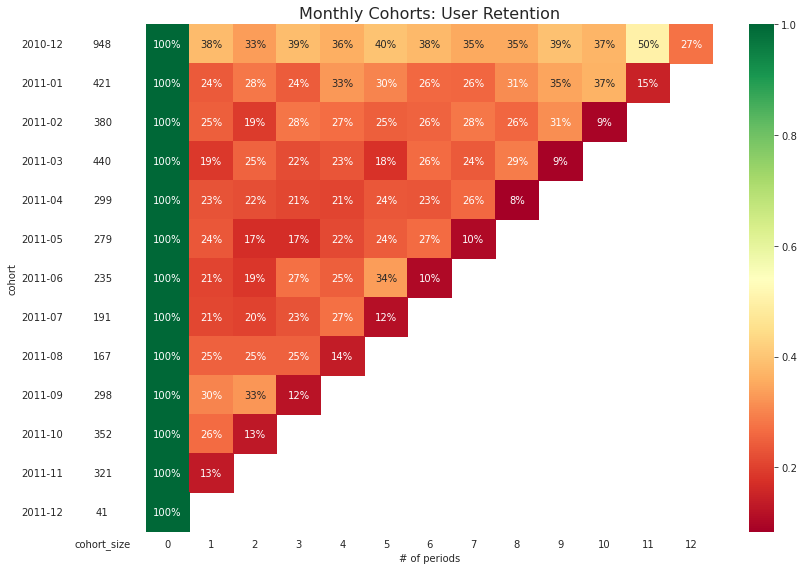

In [12]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')
    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()